# SLT-CE-2: Deterministic Annealing

Grade: 6.0

### References

<ol>
<li> Sections II.A.1 (principled derivation of deterministic annealing) and II.A.3 (Mass-constrained clustering) of 'Deterministic annealing for clustering, compression, classification, regression, and related optimization problems', Kenneth Rose, 1998, http://ieeexplore.ieee.org/document/726788/ 
</li>

<li>
The wine data set, http://www3.dsi.uminho.pt/pcortez/wine5.pdf
</li>
    
</ol>

### Setup 

In [1]:
import sklearn as skl
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import sklearn.svm as svm
from sklearn import cluster

import pandas as pd
import numpy as np
from treelib import Tree

import matplotlib.pyplot as plt
from matplotlib import cm

<h2 style="background-color:#f0b375;">
Section 4.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.0 </span>
</h2>

<p style="background-color:#adebad;">
    For this exercise, it is of utmost importance to read reference [1] about deterministic annealing clustering (DAC). Our implementation will be based on this reference. Please shortly summarize what they refer to as the <i>preferred implementation</i> of the DAC algorithm.
</p>

As presented in reference [1] above, the 'preferred implementation of the DA Algorithm' is the 'Mass Constrained DA'. In this formulation, instead of viewing all K clusters as separate clusters irrespective of their location, the algorithm only differentiates between 'distinct' (non-degenerate) cluster centroids. Moreover, in order to convey the information of how many cluster centroids are overlapping on a given centroid (referred to as 'codevector' in the paper) at any iteration during the algorithm, a sequence of parameters $\{ p_i \}_{i=1}^{K_{max}}$ are defined where $K_{max}$ is the maximally allowed centroid number. Here, each $\{ p_i \}$ denotes the fraction of codevectors that would overlap to represent a distinct centroid $y_i$ as in the case of regular DA. Moreover, it is demonstrated that this set of parameters $\{ p_i \}$ (which are initially set to be user defined parameters) satisfy the the probability distribution axioms, allowing them to denote an 'artificial' distribution on the space of distinct centroids which specifies the individual masses of each distinct centroid, which further split up at critical tempuratures. Ultimately, when a formal derivation is performed to maximize the entropy with respect to an expected cost constraint and under the normalization constraint of the $\{ p_i \}'s$, it turns out that the optimal $p_i's$ are equal to the marginal $p(y_i)'s$ induced on the space of centroids by the Entropy maximizing Gibbs Distribution $p(y_i|x)$. In other words, they optimally mimic these probabilities on these centroids. Moreover, it is concluded that this derivation once again yields the condition $\sum_{x}^{} p(x)p(y_i|x)\frac{\partial R(y_i,x)}{\partial y_i} = 0$. However, in this case, by construction, the 'tilted' probabilities $p(y_i|x)=\frac{p_ie^{\frac{-R(x,y_i)}{T}}}{\sum_i^{}p_ie^{\frac{-R(x,y_i)}{T}}}$ are used in accordance with the idea of the mass constraint. Hence, this algorithm utilizes these 'tilted' probabilities to compute the distinct centroids via EM Updates. This compensates for the weakness in DA that after overlapping centroids split, the rest of the procedure and the final solutions become dependent on with what fraction a degenerate centroid splits into two subgroups of clusters at a critical tempurature. This makes the regular DA algorithm dependent on the perturbation as well as how the centroids are initialized which in turn influence this division of centroids at critical tempuratures. In the regular DA case, a large number of overlapping centroids at a degenerate centroid may seem unuseful in terms of minimizing the expected cost but they still have positive contribution to entropy which in turn shape our solutions as we follow a maximum entropy principle. The Mass constrained clusetering idea on the other hand, by considering only each distinct codevectors and incorporating their contained 'mass' into the centroid updates, allows us to normalize out these undesirable effects of perturbation or initialization at the final solutions. This is achieved by the key idea that this modified algorithm considers the mass/population of each distinct cluster subgroup, hence providing a better heuristic that allows us to dynamically introduce new clusters only when the structure of the system suggests such additional centroids and achieves this irrespective of some user defined perturbation. Therefore, the mass clustering algorithm allows us to normalize out this effect of concentrated clusters to sufficient degree so that our algorithm is robust against the perturbations we apply to the centroids or the initialization of the centroids.

<p style="background-color:#adebad;">
    In order to avoid headaches with numerical instabilities, we first try our algorithm on a simple artificially generated data as below. Run the bloc below to have a look at the data. Later when we have everything implemented, we will examine some real world data. 
</p>

/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Text(0.5, 1.0, 'Test data')

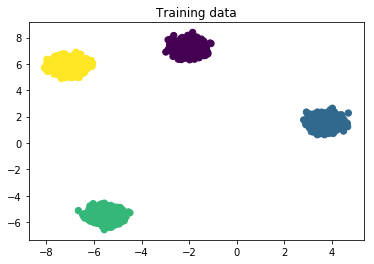

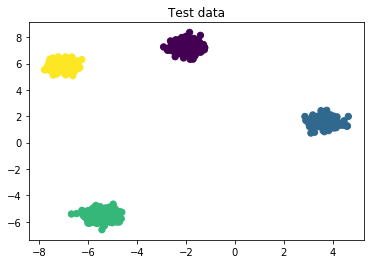

In [2]:
n_clusters = 4
ran_s = 42

# Generate artificial dataset
X, y_true = make_blobs(n_samples=7000, centers=4,
                       cluster_std=0.3, random_state=ran_s,
                       center_box=(-8.0, 8.0),
                       shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_true, train_size=6000, random_state=42)

plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=40, cmap='viridis')
plt.title("Training data")

plt.figure()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=40, cmap='viridis')
plt.title("Test data")

<p style="background-color:#adebad;">
    Implement the <b>fit method</b> for the template class DeterministicAnnealing, according to the contract outlined in its docstring. (The template class DeterministicAnnealing is in file <b>DA.py</b> which you can open in your favourite IDE) For the implementation, it may help to take a look at both <b>get_distance method</b> and <b>fit _calculate_cluster_probs method</b> and implement them as well. Of course you are free to change all these methods or/and write additional methods for your purpose.
    You can add more class methods as necessary.
    See http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html for complementary information.
</p>
<p style="background-color:#adebad;">
    While implementing, you can run the bloc below to test your implementation.
</p>

[-2.73255307  2.25256361]
T_critical is: 49.97516981371835
Tcritical is 49.97516981371836
[0.5 0.5]
(2, 2)
Tcritical is 42.569479209626635
[0.21390275 0.39304862 0.39304862]
(3, 2)
Tcritical is 14.010977952065623
[0.25283654 0.24808339 0.24808339 0.25099669]
(4, 2)
First Centroid
├── Centroid1
└── Centroid2
    ├── Centroid3
    │   ├── Centroid5
    │   └── Centroid6
    └── Centroid4



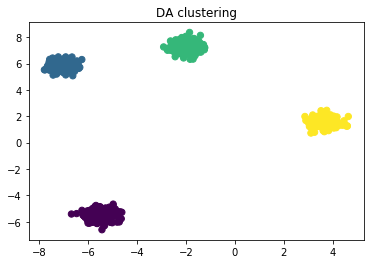

In [3]:
from DA import DeterministicAnnealingClustering

DAC = DeterministicAnnealingClustering(
    n_clusters=n_clusters, random_state=ran_s, T_min_scaler = 30, cooling_parameter = 0.99)
DAC.fit(X_train)
y_DAC = DAC.predict(X_test)
y_DAC_hard = np.argmax(y_DAC, axis=1)
plt.figure()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_DAC_hard, s=40, cmap='viridis')
plt.title("DA clustering")
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.5
<span style=font-size:50%> Complete all problems in this section to get an additional (+0.5) point to the previous points. Note that you can have a maximum of 6 points at the end.</span>
</h2>

<p style="background-color:#adebad;">
    In this section we implement a plot which will help us better understand the DA method, and could also be a help for better debugging of your implementation.
    
 <ul style="background-color:#adebad;">
        <li> 
            Modify your implementation of <b>fit</b> function such that <b>plot_phase_diagram</b> method will produce a plot similar to the phase diagram plot shown in Figure 2 of the reference paper.
        </li>
</ul>  
</p>

<ul style="background-color:#adebad;">
            Produce a phase diagram plot of the expected distortion D, as shown in figure 2 of reference [1]. For this, extend DAC.fit to save the expected distortion during annealing as an additional attribute self.distortion.
            You might also want to save the number of effective clusters and the temperature along the way.
    </ul>
</p>

#### extend DAC.fit(self, X):
    # ...
    # Save information for each (n-th) annealing step:
    # self.distortion = [d0, d1, d2, ...]
    # self.n_eff_clusters = [e0, e1, e2, ...]
    # self.temp = [t0, t1, t2, ...]
    # ...

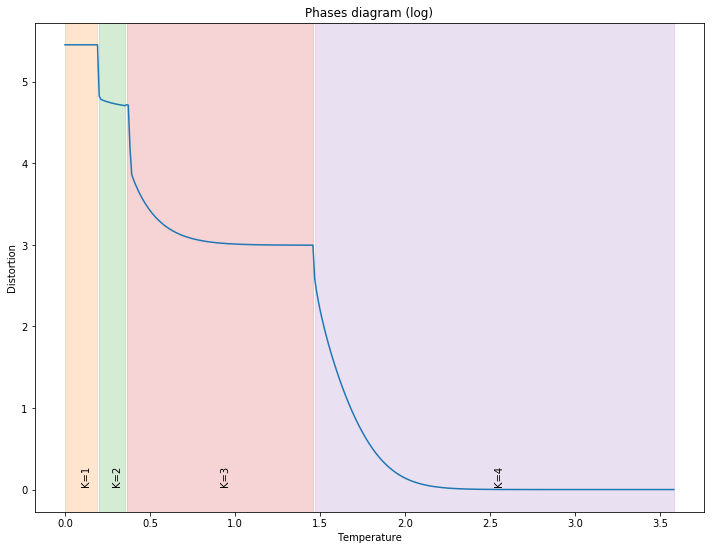

In [4]:
DAC.plot_phase_diagram()

<h2 style="background-color:#f0b375;">
Section 5.0
<span style=font-size:50%> Complete all problems in this section to get an additional (+0.5) point to the previous points.</span>
</h2>
<ul style="background-color:#adebad;">
Here we implement another plot which helps better undetrstad the dynamics of the algorithm.
        <li>
        Implement DAC.plot_bifurcation, which should create a bifurcation plot.<br>
        Modify DAC.fit to keep track of the distances, using the tree object DAC.bifurcation_tree. When a cluster splits, it creates two child nodes. Each node should store its centroid vector, and the distance to the parent centroid vector. After splitting, the parent node is not updated anymore.<br>
        In the bifurcation plot, the horizontal distance of a child node to its parent node should be exactly the distance to the parent centroid vector. The two child nodes should move in opposite directions, i.e. one to the left of the parent and one to the right.
        </li>
</ul>

This section could bit a bit annoying, you can also jump to the next sections and come back here later. 

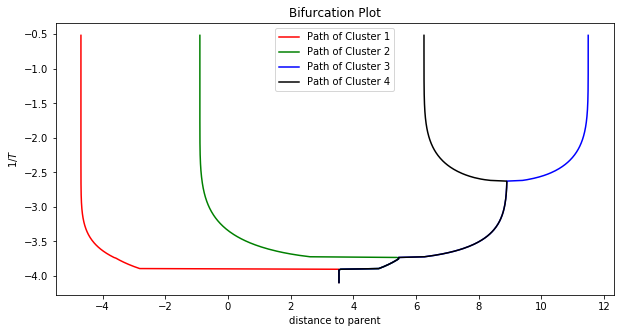

In [5]:
DAC.plot_bifurcation()

<h2 style="background-color:#f0b375;">
Section 5.5
<span style=font-size:50%> Complete all problems in this section to get an additional (+0.5) point to the previous points.</span>
</h2>

<p style="background-color:#adebad;">
Now we are ready to use some real world data. This might need some tweaking and handling of numberical instabilities. Please make sure your understand the data.
</p>

<p style="background-color:#adebad;">
Read the wine data [3], which contains 11 physiochemical attributes, and two labels (quality and color).
</p>

<p style="background-color:#adebad;">
    Create an instance of your DAC class with n_clusters = 2 and <b>fit the first 6000 samples</b> of the wine data set. Record the execution time. Furthermore, create an instance of the sklearn k-means class, and fit it with the same parameters. Again record the execution time. Make sure that the hyper parameters (initial temperature, min temperature, convergence criteria, noise, etc.) make sense and lead to a reasonable clustering
</p>

In [6]:
from DA import read_data_csv
X, y = read_data_csv("wine-data.csv", y_names=["quality", "color"])

X_normalized = skl.preprocessing.normalize(X, norm='l2')#PREPROCESSING

X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y["color"], train_size=6000, random_state=42)

/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
%%time
DAC = DeterministicAnnealingClustering(n_clusters=2, random_state=42, T_min_scaler = 120, cooling_parameter = 0.95)
DAC.fit(X_train)

[9.43762638e-02 4.94294861e-03 3.62378437e-03 4.88887661e-02
 7.59566008e-04 2.59513507e-01 9.27091968e-01 1.21937449e-02
 3.99829079e-02 7.00795477e-03 1.30438675e-01]
T_critical is: 0.06292426861675758
Tcritical is 0.06292426861675764
[0.5 0.5]
(2, 11)
First Centroid
├── Centroid1
└── Centroid2

CPU times: user 2.6 s, sys: 50.7 ms, total: 2.65 s
Wall time: 2.56 s


In [8]:
%%time
kmeans = cluster.KMeans(n_clusters=2,random_state=42)
kmeans.fit(X_train)

CPU times: user 115 ms, sys: 5.36 ms, total: 120 ms
Wall time: 91.5 ms


In [9]:
%%time
y_kmeans = kmeans.predict(X_test)


CPU times: user 1.11 ms, sys: 485 µs, total: 1.59 ms
Wall time: 1.95 ms


In [10]:
%%time
y_DAC = DAC.predict(X_test)


CPU times: user 661 µs, sys: 481 µs, total: 1.14 ms
Wall time: 721 µs


In [11]:
print('Kmeans centers:',kmeans.cluster_centers_)
print('DAC centers:',DAC.effective_centers)

Kmeans centers: [[6.14903903e-02 2.85192858e-03 2.62990986e-03 4.28368388e-02
  4.16710974e-04 2.51479127e-01 9.53032877e-01 8.51339426e-03
  2.77347085e-02 4.49586273e-03 9.09720615e-02]
 [3.16090701e-01 1.90404708e-02 1.03244222e-02 8.96904694e-02
  3.07107252e-03 3.13680780e-01 7.52200031e-01 3.70064311e-02
  1.22559478e-01 2.39443172e-02 3.96520040e-01]]
DAC centers: [[6.16245229e-02 2.86057137e-03 2.63186364e-03 4.28749804e-02
  4.18067377e-04 2.51529634e-01 9.52959982e-01 8.53012507e-03
  2.77915892e-02 4.50459601e-03 9.11459805e-02]
 [3.16988930e-01 1.90968085e-02 1.03658418e-02 8.97642990e-02
  3.08072263e-03 3.13779670e-01 7.51267798e-01 3.70952660e-02
  1.22846959e-01 2.40232141e-02 3.97510022e-01]]


In this part, we observe that the implemented DAC algorithm has reasonable performance on the given real world dataset. TO begin with, the dataset consists of 11 features for each sample and as explained in the reference [2], it is evident that certain features are semantically standing out more to characterize the clusters belonging to red and white wine. However, we observe that the scale of the given features are greatly imbalanced: the essential features are occasionally found to vary within a very small range whereas certain 'unuseful' features have much larger scales. Moreover, since our DAC algorithm is guided primarily by the eculidian distance cost objective while looking for maximum entropy solutions, we normalize the each feature with respect to the l2 norm using skl.preprocessing.normalize() module and furthermore, certain hypermarameters such as cooling_rate of T_min are adjusted such that numerical issues resulting from the data or various computational difficulties resulting from small tempurature values are tackled and we ultimately have a decent performance. Moreover, it is evident from the above results that DAC algorithm obtains 2 clusters successfully as desired and in a limited time around 2 seconds. Additionally, the guessed cluster centroids by the DAC and Kmeans algorithm are quite similar as printed above. Moreover, as we shall see in Section 6.0, Kmeans actually provides a decent clustering outcome on this dataset and yields rather linearly seperable samples when transformed to the distance space via the kmeans centroids. Thus, if we take this built-in kmeans algorithm as our reference for this part, we actually observe that the DAC algorithm at the least manages to replicate the results of the kmeans algorithm which was already successful on the given dataset. The DAC algorithm as well manages to find appropiate centroid representatives such that the transformed dataset beacomes almost linearly seperable and generates an SVM classification score comparable to the KMEANS case. This not only indicates that DAC can replicate the results of the Kmeans algorithm but it also indeed finds sufficiently good representatives of the samples in the two clusters such that data can be almost linearly seperated to a good degree on the transformed space as we shall see in the next plots. Moreover, we see how the DAC algorithm is at least as successful as the kmeans algorithm in the confusion matrix below where there are no False Negatives or False Positives relative to the kmeans classifications. This is an expected result since here, the DAC algorithm is intentionally run until very low tempuratures (so that it could safely be compared to the kmeans clustering as a reference) in which case the behaviour of the DA algorithm indeed converges to the behaviour of kmeans clustering.

<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems in this section to get an additional (+0.5) point to the previous points.</span>
</h2>
<ul style="background-color:#adebad;">
<li> Before we can compute the confusion matrix, we need to perform some post-processing on the DAC cluster assignments.
    Explain what the function postprocess (defined below) does, and why we need it. To do so, complete the docstring of the function postprocess.
        </li>
</ul>

In [12]:
def postprocess(y_DAC, y_kmeans):
    """This function goes over each hard cluster assignment produced by DAC for all samples and replaces each of these
    assignments with the cluster assignment performed by K-means on the most likely sample in each cluster acording to 
    the output of DAC. Therefore, the function uses the hard clustering assignments of DAC to refine these assignments
    by using the kmeans assignments for the most likely samples in each guessed cluster. This is equivalent to replacing 
    all the samples in the guessed DAC clusters with only the most likely samples in each as representatives and using the kmeans cluster
    assignments of these two samples as the cluster assignements for all the samples in that respective cluster. This is
    essential since when we compare the two algorithms using a confusion table in the next step, we need to be able to compare the performance
    of DAC with respect to KMEANS regarded as the relative ground truth. Therefore, for this purpose, we first evaluate how well
    the fitted KMEANS model evaluates on the representatives found by the DAC algorithm such that there are no mismatches between
    the resulting clusters or how each algorithm encodes them. In other words, we ensure that the centroids assignments encoded as 0,1 indeed
    correspond correctly to each other in DAC and KMEANS, giving us a correct confusion table metric for comparison."""
    
    y_DAC_hard = np.argmax(y_DAC, axis=1)#Hard clustering outputs of DAC, nsamples x 1
    #print(y_DAC_hard)
    
    n_clusters = len(np.unique(y_DAC_hard))#Generate empty array of size number of effectihve clusters used in DAC
    dac2kmeans = []#contains the clusters assigments of kmeans to the most likely samples in each cluster by DAC
    for cluster in range(n_clusters):
        argmax = np.argmax(y_DAC[:, cluster])#Choose the sample index most likely to be in the effective cluster denoted cluster
        dac2kmeans.append(y_kmeans[argmax])#Append the cluster assigned to this sample by kmeans
    #print(dac2kmeans)    
    y_DAC_new = []
    for dac_label in y_DAC_hard:#Go over each cluster assignment for all samples
        y_DAC_new.append(dac2kmeans[dac_label])#The resulting array consists of the indices of the most likely samples
        #by kmeans approach for each label assignment in y_DAC_
        
    #print((y_kmeans == y_DAC_new).all())
        
    return np.array(y_DAC_new)

In [13]:
#print(postprocess(y_DAC, y_kmeans))
skl.metrics.confusion_matrix(y_kmeans, postprocess(y_DAC, y_kmeans))#Relative to ykmeans, compute confusion table of ydac_new

array([[443,   0],
       [  0,  54]])

</h2>

<ul style="background-color:#adebad;">
        <li> Read the docstring of <b>transform method</b> and understand what it does.
        </li>
        <li>
        Use DAC.transform and kmeans.transform to transform both, X_train and X_test. 
        </li>
       
</ul>

In [14]:
X_train_DAC = DAC.transform(X_train)
X_test_DAC = DAC.transform(X_test)

X_train_kmeans = kmeans.transform(X_train)
X_test_kmeans = kmeans.transform(X_test)
#print(X_train_kmeans)
#print(X_train_DAC)



<ul style="background-color:#adebad;">
        <li>
        Fit an SVM classifier with default parameters to the untransformed data, and to the transformed data.
        Compare the performance of predicting whether the color of a wine is red or white.
        </li>
    </ul>

In [15]:
svm1 = svm.SVC(random_state=42)
svm1.fit(X_train, y_train)
svm1.score(X_test, y_test)

/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9094567404426559

In [16]:
svm_DAC = svm.SVC(random_state=42)
svm_DAC.fit(X_train_DAC, y_train)
svm_DAC.score(X_test_DAC, y_test)

/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9114688128772636

In [17]:
svm2 = svm.SVC(random_state=42)
svm2.fit(X_train_kmeans, y_train)
svm2.score(X_test_kmeans, y_test)

/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9134808853118712

<ul style="background-color:#adebad;">
        <li>
        Produce two scatter plots, one for X_train_DAC and one for X_train_kmeans.<br>
        Make the marker color indicate the wine color.
        </li>
    </ul>

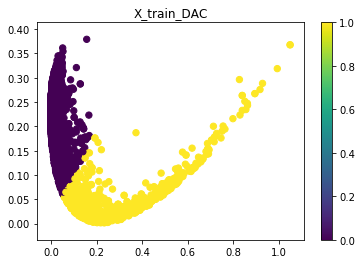

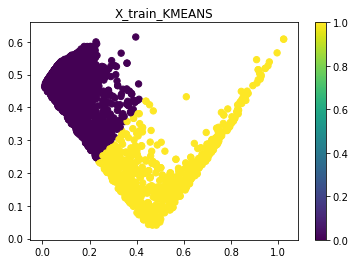

In [18]:
y_train_DAC = DAC.predict(X_train)
y_train_kmeans = kmeans.predict(X_train)

plt.figure()
plt.scatter(X_train_DAC[:, 0], X_train_DAC[:, 1], c=np.argmax(y_train_DAC, axis=1), s=40, cmap='viridis')
plt.title("X_train_DAC")
plt.colorbar()
plt.show()

plt.figure()
plt.scatter(X_train_kmeans[:, 0], X_train_kmeans[:, 1], c=y_train_kmeans, s=40, cmap='viridis')
plt.title("X_train_KMEANS")
plt.colorbar()
plt.show()

<ul style="background-color:#adebad;">
    <li>
        Create a fixed 2D embedding (e.g. with LLE, t-SNE, MDS) of the wine data and color the markers according to quality and color. Fit and transform X_train with DAC(n_clusters=2,3,4,5,6,7,8,...). Produce a plot of the SVM score svm_DAC.score(X_test_DAC, y_test) as a function of n_clusters.. Each time use marker shapes to display the cluster memberships, and compare to the labels color and quality.
    </li>
</ul>

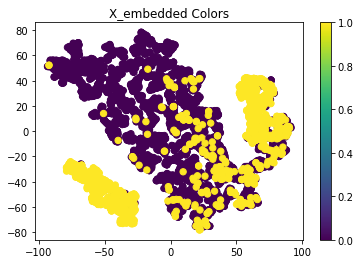

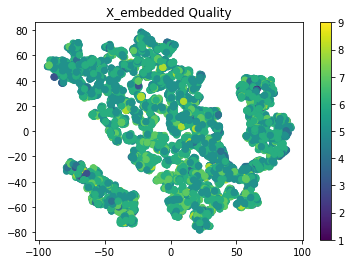

/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


[9.43762638e-02 4.94294861e-03 3.62378437e-03 4.88887661e-02
 7.59566008e-04 2.59513507e-01 9.27091968e-01 1.21937449e-02
 3.99829079e-02 7.00795477e-03 1.30438675e-01]
T_critical is: 0.06292426861675758
Tcritical is 0.06292426861675764
[0.5 0.5]
(2, 11)
First Centroid
├── Centroid1
└── Centroid2



/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[9.43762638e-02 4.94294861e-03 3.62378437e-03 4.88887661e-02
 7.59566008e-04 2.59513507e-01 9.27091968e-01 1.21937449e-02
 3.99829079e-02 7.00795477e-03 1.30438675e-01]
T_critical is: 0.06292426861675758
Tcritical is 0.06292426861675764
[0.5 0.5]
(2, 11)
Tcritical is 0.05088723731607269
[0.93252512 0.03373744 0.03373744]
(3, 11)
First Centroid
├── Centroid1
└── Centroid2
    ├── Centroid3
    └── Centroid4



/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[9.43762638e-02 4.94294861e-03 3.62378437e-03 4.88887661e-02
 7.59566008e-04 2.59513507e-01 9.27091968e-01 1.21937449e-02
 3.99829079e-02 7.00795477e-03 1.30438675e-01]
T_critical is: 0.06292426861675758
Tcritical is 0.06292426861675764
[0.5 0.5]
(2, 11)
Tcritical is 0.05088723731607269
[0.93252512 0.03373744 0.03373744]
(3, 11)
Tcritical is 0.039722333371466086
[0.91744136 0.0310839  0.0310839  0.02039084]
(4, 11)
First Centroid
├── Centroid1
└── Centroid2
    ├── Centroid3
    │   ├── Centroid5
    │   └── Centroid6
    └── Centroid4



/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[9.43762638e-02 4.94294861e-03 3.62378437e-03 4.88887661e-02
 7.59566008e-04 2.59513507e-01 9.27091968e-01 1.21937449e-02
 3.99829079e-02 7.00795477e-03 1.30438675e-01]
T_critical is: 0.06292426861675758
Tcritical is 0.06292426861675764
[0.5 0.5]
(2, 11)
Tcritical is 0.05088723731607269
[0.93252512 0.03373744 0.03373744]
(3, 11)
Tcritical is 0.039722333371466086
[0.91744136 0.0310839  0.0310839  0.02039084]
(4, 11)
Tcritical is 0.03467898695234395
[0.90387589 0.05597369 0.02011615 0.01001714 0.01001714]
(5, 11)
First Centroid
├── Centroid1
└── Centroid2
    ├── Centroid3
    │   ├── Centroid5
    │   └── Centroid6
    └── Centroid4
        ├── Centroid7
        └── Centroid8



/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[9.43762638e-02 4.94294861e-03 3.62378437e-03 4.88887661e-02
 7.59566008e-04 2.59513507e-01 9.27091968e-01 1.21937449e-02
 3.99829079e-02 7.00795477e-03 1.30438675e-01]
T_critical is: 0.06292426861675758
Tcritical is 0.06292426861675764
[0.5 0.5]
(2, 11)
Tcritical is 0.05088723731607269
[0.93252512 0.03373744 0.03373744]
(3, 11)
Tcritical is 0.039722333371466086
[0.91744136 0.0310839  0.0310839  0.02039084]
(4, 11)
Tcritical is 0.03467898695234395
[0.90387589 0.05597369 0.02011615 0.01001714 0.01001714]
(5, 11)
Tcritical is 0.028779673527481384
[0.88656099 0.04919717 0.02807524 0.02976669 0.00319996 0.00319996]
(6, 11)
First Centroid
├── Centroid1
└── Centroid2
    ├── Centroid3
    │   ├── Centroid5
    │   └── Centroid6
    └── Centroid4
        ├── Centroid7
        └── Centroid8
            ├── Centroid10
            └── Centroid9



/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[9.43762638e-02 4.94294861e-03 3.62378437e-03 4.88887661e-02
 7.59566008e-04 2.59513507e-01 9.27091968e-01 1.21937449e-02
 3.99829079e-02 7.00795477e-03 1.30438675e-01]
T_critical is: 0.06292426861675758
Tcritical is 0.06292426861675764
[0.5 0.5]
(2, 11)
Tcritical is 0.05088723731607269
[0.93252512 0.03373744 0.03373744]
(3, 11)
Tcritical is 0.039722333371466086
[0.91744136 0.0310839  0.0310839  0.02039084]
(4, 11)
Tcritical is 0.03467898695234395
[0.90387589 0.05597369 0.02011615 0.01001714 0.01001714]
(5, 11)
Tcritical is 0.028779673527481384
[0.88656099 0.04919717 0.02807524 0.02976669 0.00319996 0.00319996]
(6, 11)
Tcritical is 0.022918751093664133
[8.67653438e-01 4.96293846e-02 1.85174315e-02 1.85174315e-02
 3.53714594e-02 5.12716688e-04 9.79813828e-03]
(7, 11)
First Centroid
├── Centroid1
└── Centroid2
    ├── Centroid3
    │   ├── Centroid5
    │   └── Centroid6
    │       ├── Centroid11
    │       └── Centroid12
    └── Centroid4
        ├── Centroid7
        └── Centroid8
  

/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[9.43762638e-02 4.94294861e-03 3.62378437e-03 4.88887661e-02
 7.59566008e-04 2.59513507e-01 9.27091968e-01 1.21937449e-02
 3.99829079e-02 7.00795477e-03 1.30438675e-01]
T_critical is: 0.06292426861675758
Tcritical is 0.06292426861675764
[0.5 0.5]
(2, 11)
Tcritical is 0.05088723731607269
[0.93252512 0.03373744 0.03373744]
(3, 11)
Tcritical is 0.039722333371466086
[0.91744136 0.0310839  0.0310839  0.02039084]
(4, 11)
Tcritical is 0.03467898695234395
[0.90387589 0.05597369 0.02011615 0.01001714 0.01001714]
(5, 11)
Tcritical is 0.028779673527481384
[0.88656099 0.04919717 0.02807524 0.02976669 0.00319996 0.00319996]
(6, 11)
Tcritical is 0.022918751093664133
[8.67653438e-01 4.96293846e-02 1.85174315e-02 1.85174315e-02
 3.53714594e-02 5.12716688e-04 9.79813828e-03]
(7, 11)
Tcritical is 0.02193311311257825
[8.64148366e-01 4.37178139e-02 2.63467807e-02 1.90560697e-02
 3.59252896e-02 5.67577917e-04 5.11905092e-03 5.11905092e-03]
(8, 11)
First Centroid
├── Centroid1
└── Centroid2
    ├── Centroid

/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[9.43762638e-02 4.94294861e-03 3.62378437e-03 4.88887661e-02
 7.59566008e-04 2.59513507e-01 9.27091968e-01 1.21937449e-02
 3.99829079e-02 7.00795477e-03 1.30438675e-01]
T_critical is: 0.06292426861675758
Tcritical is 0.06292426861675764
[0.5 0.5]
(2, 11)
Tcritical is 0.05088723731607269
[0.93252512 0.03373744 0.03373744]
(3, 11)
Tcritical is 0.039722333371466086
[0.91744136 0.0310839  0.0310839  0.02039084]
(4, 11)
Tcritical is 0.03467898695234395
[0.90387589 0.05597369 0.02011615 0.01001714 0.01001714]
(5, 11)
Tcritical is 0.028779673527481384
[0.88656099 0.04919717 0.02807524 0.02976669 0.00319996 0.00319996]
(6, 11)
Tcritical is 0.022918751093664133
[8.67653438e-01 4.96293846e-02 1.85174315e-02 1.85174315e-02
 3.53714594e-02 5.12716688e-04 9.79813828e-03]
(7, 11)
Tcritical is 0.02193311311257825
[8.64148366e-01 4.37178139e-02 2.63467807e-02 1.90560697e-02
 3.59252896e-02 5.67577917e-04 5.11905092e-03 5.11905092e-03]
(8, 11)
Tcritical is 0.017355934410537118
[8.46390042e-01 2.9313501

/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[9.43762638e-02 4.94294861e-03 3.62378437e-03 4.88887661e-02
 7.59566008e-04 2.59513507e-01 9.27091968e-01 1.21937449e-02
 3.99829079e-02 7.00795477e-03 1.30438675e-01]
T_critical is: 0.06292426861675758
Tcritical is 0.06292426861675764
[0.5 0.5]
(2, 11)
Tcritical is 0.05088723731607269
[0.93252512 0.03373744 0.03373744]
(3, 11)
Tcritical is 0.039722333371466086
[0.91744136 0.0310839  0.0310839  0.02039084]
(4, 11)
Tcritical is 0.03467898695234395
[0.90387589 0.05597369 0.02011615 0.01001714 0.01001714]
(5, 11)
Tcritical is 0.028779673527481384
[0.88656099 0.04919717 0.02807524 0.02976669 0.00319996 0.00319996]
(6, 11)
Tcritical is 0.022918751093664133
[8.67653438e-01 4.96293846e-02 1.85174315e-02 1.85174315e-02
 3.53714594e-02 5.12716688e-04 9.79813828e-03]
(7, 11)
Tcritical is 0.02193311311257825
[8.64148366e-01 4.37178139e-02 2.63467807e-02 1.90560697e-02
 3.59252896e-02 5.67577917e-04 5.11905092e-03 5.11905092e-03]
(8, 11)
Tcritical is 0.017355934410537118
[8.46390042e-01 2.9313501

/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/envs/slt-ce/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


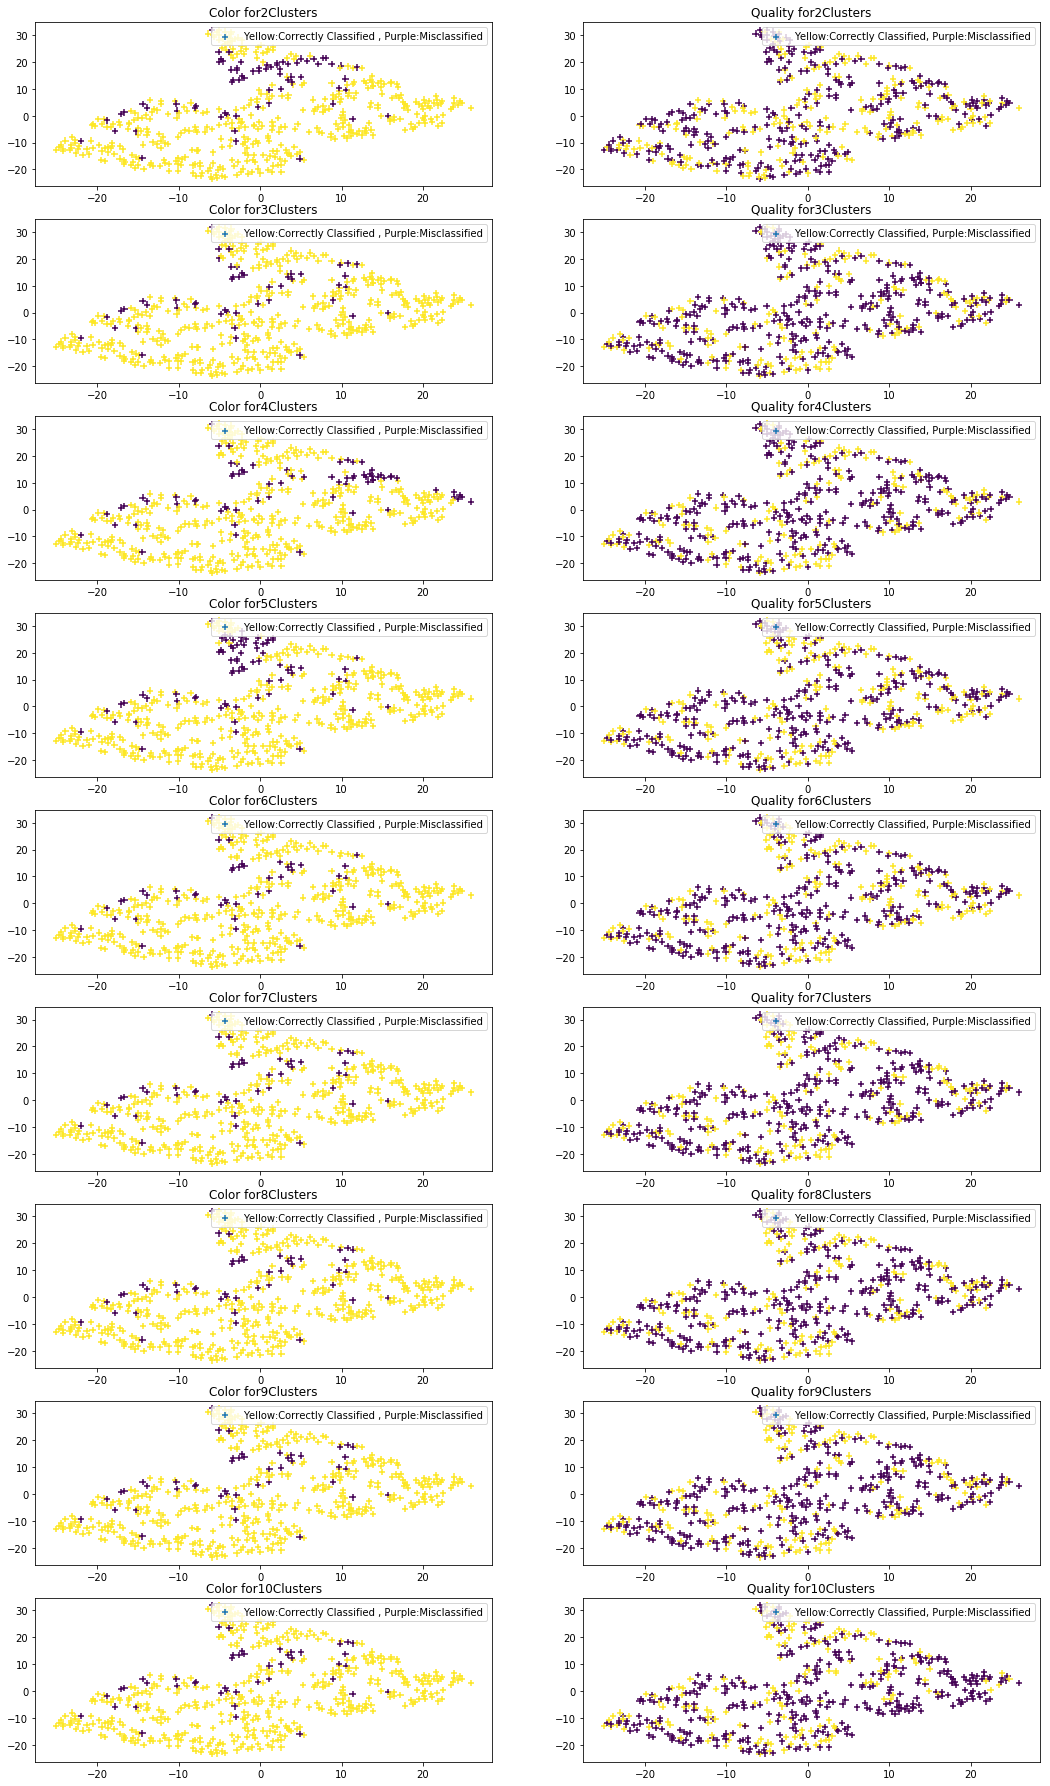

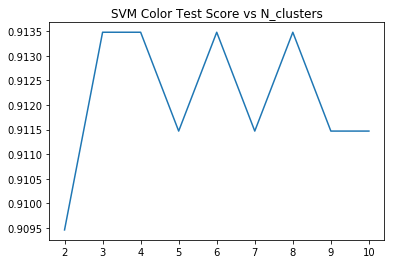

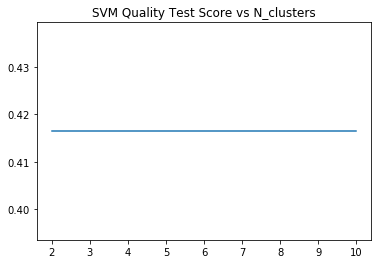

In [20]:
"""
    %%time
    lle = skl.manifold.LocallyLinearEmbedding(random_state=...)
    lle.fit(...)
"""

from DA import read_data_csv

X, y = read_data_csv("wine-data.csv", y_names=["quality", "color"])

embedding = skl.manifold.TSNE(n_components = 2, random_state=42)
X_embedded = embedding.fit_transform(X)#Transform the whole wine data(unnormalized and unseparated)

y_color = y['color'][:,0]
y_quality = y['quality'][:,0]

y_color[y_color =='red']=1
y_color[y_color=='white']=0


plt.figure()
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_color, s=40, cmap='viridis')
plt.title("X_embedded Colors")
plt.colorbar()
plt.show()

plt.figure()
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_quality, s=40, cmap='viridis')
plt.title("X_embedded Quality")
plt.colorbar()
plt.show()


X_normalized = skl.preprocessing.normalize(X, norm='l2')#PREPROCESSING

X_train, X_test, y_train_color, y_test_color, y_train_quality, y_test_quality = train_test_split(
    X_normalized, y["color"], y['quality'], train_size=6000, random_state=42)

y_test_color[y_test_color =='red']=1
y_test_color[y_test_color=='white']=0

y_train_color[y_train_color =='red']=1
y_train_color[y_train_color=='white']=0

y_train_color = y_train_color.ravel()
y_test_color = y_test_color.ravel()
y_train_color = y_train_color.astype('float')
y_test_color = y_test_color.astype('float')

y_train_quality = y_train_quality.ravel()
y_test_quality = y_test_quality.ravel()
y_train_quality = y_train_quality.astype('float')
y_test_quality = y_test_quality.astype('float')

cluster_options = [2,3,4,5,6,7,8,9,10]
svm_scores_color = []
svm_scores_quality = []

fig, axs = plt.subplots(len(cluster_options),2, figsize=(18, 32))

for n_cluster in cluster_options:
    if n_cluster <= 8:
        scaler=9
    else:
        scaler=9
    #kmeans = cluster.KMeans(n_clusters=n_cluster, random_state=42)
    #kmeans.fit(X_train)
    #y_kmeans = kmeans.predict(X_test)
    #X_train_kmeans = kmeans.transform(X_train)
    #X_test_kmeans = kmeans.transform(X_test)
    #svm_kmeans = svm.SVC(random_state=42)
    #svm_kmeans.fit(X_train_kmeans, y_train)
    #svm_scores.append(svm_kmeans.score(X_test_kmeans, y_test))
    
    DAC = DeterministicAnnealingClustering(n_clusters=n_cluster, random_state=42, T_min_scaler = scaler, cooling_parameter=0.955)
    DAC.fit(X_train)
    y_DAC = DAC.predict(X_test)
    X_train_DAC = DAC.transform(X_train)
    X_test_DAC = DAC.transform(X_test)
    
    svm_DAC_color = svm.SVC(random_state=42)
    svm_DAC_color.fit(X_train_DAC, y_train_color)
    svm_scores_color.append(svm_DAC_color.score(X_test_DAC, y_test_color))
    
    svm_DAC_quality = svm.SVC(random_state=42)
    svm_DAC_quality.fit(X_train_DAC, y_train_quality)
    svm_scores_quality.append(svm_DAC_quality.score(X_test_DAC, y_test_quality))
    
    y_test_DAC = DAC.predict(X_test)#Xtrain of Xtest????
    y_test_DAC_hard = np.argmax(y_test_DAC, axis=1)
    
    embedding_itr = skl.manifold.LocallyLinearEmbedding(random_state=42, n_components = 2)
    X_embedded_itr = embedding.fit_transform(X_test)#Xtrain or X_DAC????
    
    axs[n_cluster-2,0].set_title('Color for'+str(n_cluster)+'Clusters')
    axs[n_cluster-2,0].scatter(X_embedded_itr[:, 0], X_embedded_itr[:, 1], c=1*(postprocess(y_test_DAC, y_test_color)==y_test_color), s=40, cmap='viridis', marker='+')
    axs[n_cluster-2,0].legend(['Yellow:Correctly Classified , Purple:Misclassified'])
    axs[n_cluster-2,1].set_title('Quality for'+str(n_cluster)+'Clusters')
    axs[n_cluster-2,1].scatter(X_embedded_itr[:, 0], X_embedded_itr[:, 1], c=1*(postprocess(y_test_DAC, y_test_quality)==y_test_quality), s=40, cmap='viridis', marker='+')
    axs[n_cluster-2,1].legend(['Yellow:Correctly Classified, Purple:Misclassified'])
    #print((y_test_color==y_test_DAC_hard))
    #WHAT TO USE AS LABELS???
    
    
plt.figure()
plt.plot(np.arange(2,cluster_options[-1]+1), svm_scores_color)
plt.title("SVM Color Test Score vs N_clusters")
plt.figure()
plt.plot(np.arange(2,cluster_options[-1]+1), svm_scores_quality)
plt.title("SVM Quality Test Score vs N_clusters")
plt.show()
    

<ul style="background-color:#adebad;">
        <li>
            So far, our implementation of DAC assumed that our data is compatible with the euclidian metric. Argue why this assumption is not justified for the wine-data. Suggest a better alternative (no implementation required!).
        </li>
    </ul>
</p>



The euclidian metric perhaps isn't the best cost to evaulate the variation of samples in the given dataset due to a couple of reasons. Firstly, when we investiage the dataset as presented in reference [2], we observe that the measurements for each feature represents a different categorical information. For instance while one feature stands for the pH measurement of the wine, another feature indicates the concentration of various chemicals in the wine. Not only these features have diffenerent semantic meanings, they are also measured in different units. These units are generally not compatible with each other and moreover, heuristically not compatible with the euclidian metric. To elaborate, the euclidian cost, which blindly computes the squared difference between these measurements isn't guaranteed to provide a good heuristic that actually represents the variation in a given feature. For instance, pH values are measured in logarithmic scale which can't be naturally compared with respect to the euclidian scale. Moreover, as implied in Section 5.5 briefly, the scales of the different given features are also different and it is not immediately clear from the data how the scales of these features can be adapted to the euclidian metric. Moreover, it also isn't clear how much emphasis should be put on the variation of which feature based on our understanding of the two clusters. In the clustering algorithm, the euclidian difference cost puts emphasis on each feature depending on the magnitude of the relative scale of the feature such that this feature becomes more decisive during the clustering process. As we recall, this uncertainty was one of the reasons why all the features were blandly normalized in Section 5.5. Thus, the euclidian metric in fact fails to completely capture the variation in the data and thus doesn't lead to perfectly adequate representative prototypes. Lastly, the given features do not obey the inherent orthogonal feature assumptions of the euclidian metric. For example, certain features such as fixed_acidity and citric_acid are surely correlated by definition. In accordance with these theoretical thoughts, it is also evident from the above plots that no matter how we adjust the number of clusters used, the clustering with respect to wine color is imperfect for any number of clusters present. Additionally, we observe that the clustering performance with respect to the wine quality labels are far from perfect and in this case the algorithm is insufficient to cluster the data even when large number of clusters are allowed. This might be due to the fact that the data should be seperated into more clusters in this case which definitely requires a far better heuristic to represent tha data than euclidian difference metric. An alternative implementation may be to consider Histogram Clustering. For this purpose, the pH and alcohol per volume measurements can be easily converted into $g/dm^3$ units by their definition. This allows us to refine all the features in a common unit so that we resolve the different units issue to some degree and have some choerence among the units of our measurements. Furthermore, now that all the features represent the abundance of some distinctive chemical etc. in the wine (more explicitly, their concentration or frequency of occurence), we can heuristically choose a better representation for our data and features and represent them as a pair of dyads, i.e. we can sumarize the features given for a sample as a histogram of our original features which now all represent certain abundance values and have the same scale. Therefore, it is natural to adapt to this representation for clustering our data. Thus, using histogram clustering compatible with this representation, we can perform an analogous DAC algorithm in a probability simplex and guess prototypical probability distributions $q(y|x)$ of features given the data. Furthermore, in accordance with this algorithm, we can also use the natural analagous of euclidian metric of regular DAC which is a KL Divergence measure between our estimate $q(y|x)$ and the emprical distribution $p(y|x)$. Thus, we perform clustering on a probability simplex, using a histogram of features as an alternative which naturally now corresponds to the frequency of occurences of various distinctive qualities inside the wine samples. Moreover, we can be guided by the KL divergence metric in order to find better and more intuitive representatives of the clusters 'centroids', $q(y|x)$'s, in the hope that this adaptation yields better clustering results on the probability simplex by tackling the scale and euclidian compatibility issues described earlier.